Using device: cuda
Processing folder: /home/khare.aks/Dataset/combined/COVID/COVID
Processing folder: /home/khare.aks/Dataset/combined/NORMAL/NORMAL
Processing folder: /home/khare.aks/Dataset/combined/PNEUMONIA/PNEUMONIA
Processing folder: /home/khare.aks/Dataset/combined/Tuberculosis/Tuberculosis
Epoch 1/20
Train Loss: 0.5333, Train Acc: 0.7981
Val Loss: 0.3652, Val Acc: 0.8661
Epoch 2/20
Train Loss: 0.3302, Train Acc: 0.8793
Val Loss: 0.2910, Val Acc: 0.8818
Epoch 3/20
Train Loss: 0.2781, Train Acc: 0.8968
Val Loss: 0.2616, Val Acc: 0.9010
Epoch 4/20
Train Loss: 0.2400, Train Acc: 0.9123
Val Loss: 0.3054, Val Acc: 0.8800
Epoch 5/20
Train Loss: 0.2126, Train Acc: 0.9218
Val Loss: 0.2260, Val Acc: 0.9148
Epoch 6/20
Train Loss: 0.1844, Train Acc: 0.9342
Val Loss: 0.2110, Val Acc: 0.9244
Epoch 7/20
Train Loss: 0.1665, Train Acc: 0.9395
Val Loss: 0.2280, Val Acc: 0.9214
Epoch 8/20
Train Loss: 0.1549, Train Acc: 0.9451
Val Loss: 0.2175, Val Acc: 0.9250
Epoch 9/20
Train Loss: 0.1386, Train 

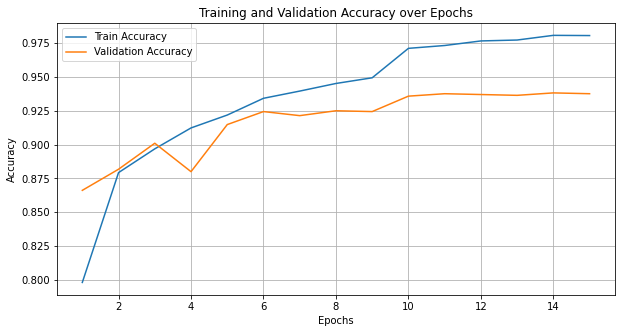

In [ ]:
# Libraries
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from PIL import Image

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

# Data loading and preparation
data_dir = '/home/khare.aks/Dataset/combined/'

# Initialize lists for image paths and labels
image_paths = []
labels = []

# Traverse dataset
for folder in os.listdir(data_dir):
    outer_folder_path = os.path.join(data_dir, folder)
    if os.path.isdir(outer_folder_path):
        inner_folder_path = os.path.join(outer_folder_path, folder)
        if os.path.isdir(inner_folder_path):
            print(f"Processing folder: {inner_folder_path}")
            for file in os.listdir(inner_folder_path):
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    file_path = os.path.join(inner_folder_path, file)
                    image_paths.append(file_path)
                    labels.append(folder)

# Create DataFrame
data_frame = pd.DataFrame({'image_paths': image_paths, 'labels': labels})
label_mapping = {label: idx for idx, label in enumerate(data_frame['labels'].unique())}
data_frame['labels'] = data_frame['labels'].map(label_mapping)

# Split data
strat = data_frame['labels']
train_df, semi_split_df = train_test_split(data_frame, train_size=0.8, shuffle=True, random_state=123, stratify=strat)
strat = semi_split_df['labels']
valid_df, test_df = train_test_split(semi_split_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

# Custom Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        self.class_to_idx = {label: idx for idx, label in enumerate(dataframe['labels'].unique())}
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        try:
            img_path = self.dataframe.iloc[idx]['image_paths']
            label = self.dataframe.iloc[idx]['labels']
            image = Image.open(img_path).convert('L')  # Convert to grayscale for LeNet
            
            if self.transform:
                image = self.transform(image)
            return image, label
        except Exception as e:
            print(f"Error loading image {img_path}: {str(e)}")
            return None

# Transforms
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # LeNet expects 32x32 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize for grayscale
])

# Datasets and DataLoaders
batch_size = 16

train_dataset = ImageDataset(train_df, transform=transform)
valid_dataset = ImageDataset(valid_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class LeNet(nn.Module):
    def __init__(self, num_classes):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        # Compute the output size after the convolutional layers
        # For 32x32 input: ((32 - 5 + 2*2)/1 + 1) -> 32 (conv1) -> 16 (pool1) -> 12 (conv2) -> 6 (pool2)
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # Corrected size
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Loss and optimizer
model = LeNet(num_classes=len(label_mapping)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Training function
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_val_loss = float('inf')
    no_improve_epochs = 0
    early_stopping_patience = 5

    train_acc_list = []
    val_acc_list = []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_acc = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_acc += (preds == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0
        val_acc = 0
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_acc += (preds == labels).sum().item()

        val_loss /= len(valid_loader)
        val_acc /= len(valid_loader.dataset)

        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_epochs = 0
            torch.save(model.state_dict(), 'lenet_best_model.pth')
        else:
            no_improve_epochs += 1

        scheduler.step(val_loss)

        if no_improve_epochs >= early_stopping_patience:
            print("Early stopping triggered")
            break

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Train Accuracy')
    plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.savefig('lenet_training_validation_accuracy.png')
    plt.show()
    plt.close()

# Train the model
train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler)

# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.savefig('lenet_confusion_matrix.png')
    plt.show()
    plt.close()

    return accuracy_score(all_labels, all_preds)

# Load and evaluate model
model.load_state_dict(torch.load('lenet_best_model.pth'))
test_accuracy = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.4f}")
